### CNN...

In [ ]:
!pip install keras_cv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 394 kB 8.6 MB/s 


In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras_cv


gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteR2XO9G/cifar10-train.tfrecord*...:   0%|          | 0/…

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling ~/tensorflow_datasets/cifar10/3.0.2.incompleteR2XO9G/cifar10-test.tfrecord*...:   0%|          | 0/1…

Dataset cifar10 downloaded and prepared to ~/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_path='~/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,

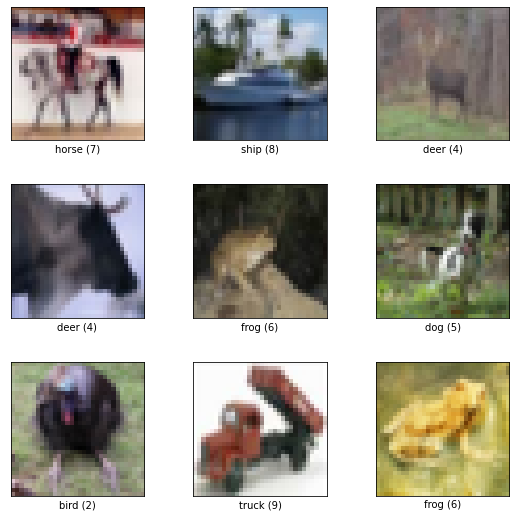

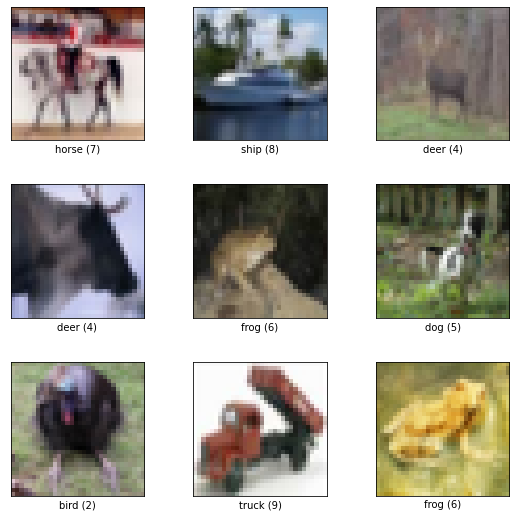

In [ ]:
#1. get cifar from tensorflow_datasets
cifar, info = tfds.load('cifar10', split=['train', 'test'], as_supervised=True, with_info=True)
train_ds = cifar[0]
val_ds = cifar[1]

print(info)
tfds.show_examples(train_ds, info) 
     

In [ ]:
for name in info.features['label'].names:
        print(name, info.features['label'].str2int(name))
     

airplane 0
automobile 1
bird 2
cat 3
deer 4
dog 5
frog 6
horse 7
ship 8
truck 9


In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

(32, 32, 3) ()


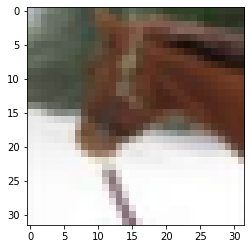

Label : 7


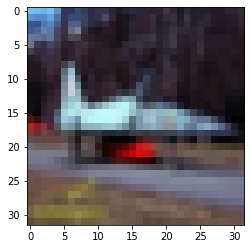

Label : 0


In [ ]:
##2. write function to create the dataset that we want
def preprocess(data, batch_size) :
    ##Image should be float
    data = data.map(lambda x, t: (tf.cast(x, tf.float32), t))
    ##sloppy input normalization, just bringing image values from range [0, 255] to [-1, 1]
    data = data.map(lambda x, t: ((x/128.)-1., t))
    ##create one-hot targets
    data = data.map(lambda x, t: (x, tf.one_hot(t, depth=10)))
    ##cache this progress in memory, as there is no need to redo it; it is deterministic after all
    data = data.cache()
    ##shuffle, batch, prefetch
    np.random.seed(420)
    data = data.shuffle(1000)
    data = data.batch(batch_size)
    data = data.prefetch(20)  ## data.prefetch(tf.data.AUTOTUNE)
    
    return data


###########################################################
train = preprocess(train_ds, batch_size=32)
val = preprocess(val_ds, batch_size=32)

###########################################################
import matplotlib.pyplot as plt
d1, d2 = val_ds.take(2)
print(d1[0].shape, d1[1].shape)

plt.imshow(d1[0].numpy().reshape(32, 32, 3), cmap='binary')
plt.show()
print(f"Label : {d1[1]}") 

plt.imshow(d2[0].numpy().reshape(32, 32, 3), cmap='binary')
plt.show()
print(f"Label : {d2[1]}") 

In [ ]:
from tensorflow.keras.layers import Dense

class BasicConv(tf.keras.Model):
  def __init__(self, L1_reg=0, L2_reg=0, dropout_rate=0, batch_norm=False, label_smoothing=0):
    super(BasicConv, self).__init__() 
    
    kernel_regularizer=tf.keras.regularizers.L2(L2_reg) if L2_reg else None
    kernel_regularizer=tf.keras.regularizers.L1(L1_reg) if L1_reg else None

    # https://www.youtube.com/watch?v=Jp_PkyS8RUw
    self.dropout_rate = dropout_rate
    if self.dropout_rate:
      self.dropout_layer = tf.keras.layers.Dropout(dropout_rate)
    
    self.metrics_list = [ tf.keras.metrics.CategoricalAccuracy(name="acc"),
                          tf.keras.metrics.TopKCategoricalAccuracy(3,name="top-3-acc"), 
                          tf.keras.metrics.Mean(name="loss"),
                          ### https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
                          tf.keras.metrics.Mean(name="total_frobenius_norm")]
    ## "from_logits=True attribute inform the loss function that the output values 
    ##  generated by the model are not normalized, a.k.a. logits" 
    self.loss_function = tf.keras.losses.CategoricalCrossentropy(label_smoothing=label_smoothing)  ## from_logits=True
    self.optimizer = tf.keras.optimizers.Adam()

    self.convlayer1 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.convlayer2 = tf.keras.layers.Conv2D(filters=24, kernel_size=3, padding='same', activation='relu')
    self.pooling = tf.keras.layers.MaxPooling2D(pool_size=2, strides=2)

    self.convlayer3 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.convlayer4 = tf.keras.layers.Conv2D(filters=48, kernel_size=3, padding='same', activation='relu')
    self.global_pool = tf.keras.layers.GlobalAvgPool2D()

    self.out = tf.keras.layers.Dense(10, activation='softmax')

  def call(self, x, training=False) :
    
    x = self.convlayer1(x)
    x = self.dropout_layer(x, training) if self.dropout_rate else x
    x = self.convlayer2(x)
    x = self.dropout_layer(x, training) if self.dropout_rate else x
    x = self.pooling(x)
    x = self.convlayer3(x)
    x = self.dropout_layer(x, training) if self.dropout_rate else x
    x = self.convlayer4(x)
    x = self.dropout_layer(x, training) if self.dropout_rate else x
    x = self.global_pool(x)
    x = self.out(x)
    x = self.dropout_layer(x, training) if self.dropout_rate else x

    return x
  
  ## 3. metrics property
  @ property
  def metrics(self):
    ## return a list with all metrics in the model
    return self.metrics_list

  def reset_metrics(self):
    for metric in self.metrics:
      metric.reset_state()
  
  ## ...
  def compute_frobenius(self):
    frobenius_norm = tf.zeros((1,))
    for var in self.trainable_variables:
      frobenius_norm += tf.norm(var, ord="euclidean")

    return frobenius_norm
  
  ## 5. train step method
  @tf.function
  def train_step(self, data):
    x, t = data
    with tf.GradientTape() as tape:
      output = self(x, training=True)
      loss = self.loss_function(t, output)
        
    gradients = tape.gradient(loss, self.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    
    ## update the state of the metrics according to loss
    self.metrics[3].update_state(self.compute_frobenius())
    self.metrics[0].update_state(t, output)
    self.metrics[1].update_state(t, output)
    self.metrics[2].update_state(loss)
    ## return a dictionary with metric names as keys and metric results as values
    return {m.name : m.result() for m in self.metrics}

  ## 6. test_step method
  @tf.function
  def test_step(self, data):
    x, t = data
    ## same as train step (without parameter updates)
    output = self(x, training=False)
    loss = self.loss_function(t, output)

    self.metrics[3].update_state(self.compute_frobenius())
    self.metrics[0].update_state(t, output)
    self.metrics[1].update_state(t, output)
    self.metrics[2].update_state(loss)

    return {m.name : m.result() for m in self.metrics}


## Testing the model 
def try_model(model, ds):
  for x, t in ds.take(5):
    y = model(x)

model = BasicConv()
try_model(model, train)
model.summary()

#%load_ext tensorboard
#%tensorboard --logdir logs/
     

Model: "basic_conv_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          multiple                  672       
                                                                 
 conv2d_21 (Conv2D)          multiple                  5208      
                                                                 
 max_pooling2d_5 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_22 (Conv2D)          multiple                  10416     
                                                                 
 conv2d_23 (Conv2D)          multiple                  20784     
                                                                 
 global_average_pooling2d_5   multiple                 0         
 (GlobalAveragePooling2D)                             

In [ ]:
import datetime
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    train_log_path = f"logs/{config_name}/{current_time}/train"
    val_log_path = f"logs/{config_name}/{current_time}/val"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    # log writer for validation metrics
    val_summary_writer = tf.summary.create_file_writer(val_log_path)
    return train_summary_writer, val_summary_writer

train_summary_writer, val_summary_writer = create_summary_writers(config_name="RUN1")

In [ ]:
import pprint
import tqdm

def training_loop(model, n_epochs, train, test, train_summary_writer, val_summary_writer, save_path) :
  training_metrics = {metric.name: [] for metric in model.metrics}
  testing_metrics = {metric.name: [] for metric in model.metrics}

  for e in range(n_epochs) :
    train = train.shuffle(buffer_size=5)
    print(f"Epoch {e}:")

    for batch in tqdm.tqdm(train, position=0, leave=True):
      metrics = model.train_step(batch)
      for name, value in metrics.items() :
        training_metrics[name].append(value)
      
      # logging the validation metrics to the log file which is used by tensorboard
      with train_summary_writer.as_default():
        for metric in model.metrics:
          tf.summary.scalar(f"{metric.name}", metric.result(), step=e)

    print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
    
    # 4. reset metric objects
    model.reset_metrics()

    # 5. evaluate on validation data
    for batch in test:
      metrics = model.test_step(batch)
      for name, value in metrics.items() :
        testing_metrics[name].append(value)
      # 6. log validation metrics
      with val_summary_writer.as_default() :
          # for scalar metrics:
          for metric in model.metrics:
                  tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
        
    print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])
    # 7. reset metric objects
    model.reset_metrics()

  # 8. save model weights if save_path is given
  if save_path:
    model.save_weights(save_path)
  
  metrics = {metric.name: [training_metrics[metric.name], testing_metrics[metric.name]] for metric in model.metrics}
  return metrics

### Test model with different optimisation techniques

In [ ]:
L2_reg=0.001
dropout_rate=0
batch_norm = False
label_smoothing=0

model = BasicConv(L1_reg=0, L2_reg=L2_reg, dropout_rate=dropout_rate, batch_norm=batch_norm, label_smoothing=label_smoothing)

Model: "basic_conv_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           multiple                  672       
                                                                 
 conv2d_9 (Conv2D)           multiple                  5208      
                                                                 
 max_pooling2d_2 (MaxPooling  multiple                 0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          multiple                  10416     
                                                                 
 conv2d_11 (Conv2D)          multiple                  20784     
                                                                 
 global_average_pooling2d_2   multiple                 0         
 (GlobalAveragePooling2D)                             

In [ ]:
def smooth(data, level):
    assert level > 1
    data = np.array([data[0]] * (level//2) + data + [data[-1]] * (level//2 - ((level + 1)%2)))
    kernel = np.array([1/level] * level)
    return np.convolve(kernel, data, 'valid')


In [ ]:
metrics = training_loop(model, 15, 
          train, val, 
          train_summary_writer, val_summary_writer, 
          "regularized_model_label_smoothing")

Epoch 0:


100%|██████████| 1563/1563 [03:19<00:00,  7.82it/s]


['acc: 0.34808000922203064', 'top-3-acc: 0.6994400024414062', 'loss: 1.7315106391906738', 'total_frobenius_norm: 30.492149353027344']
['val_acc: 0.4343999922275543', 'val_top-3-acc: 0.7767999768257141', 'val_loss: 1.5396605730056763', 'val_total_frobenius_norm: 35.94007873535156']
Epoch 1:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.48344001173973083', 'top-3-acc: 0.8127999901771545', 'loss: 1.422761082649231', 'total_frobenius_norm: 40.500831604003906']
['val_acc: 0.5004000067710876', 'val_top-3-acc: 0.8251000046730042', 'val_loss: 1.3606160879135132', 'val_total_frobenius_norm: 44.56047821044922']
Epoch 2:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.5535600185394287', 'top-3-acc: 0.8551999926567078', 'loss: 1.2446043491363525', 'total_frobenius_norm: 47.81962203979492']
['val_acc: 0.546999990940094', 'val_top-3-acc: 0.8539999723434448', 'val_loss: 1.2650357484817505', 'val_total_frobenius_norm: 50.841800689697266']
Epoch 3:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.5968199968338013', 'top-3-acc: 0.8773199915885925', 'loss: 1.1361076831817627', 'total_frobenius_norm: 53.480594635009766']
['val_acc: 0.5889999866485596', 'val_top-3-acc: 0.8755000233650208', 'val_loss: 1.1443346738815308', 'val_total_frobenius_norm: 56.08857727050781']
Epoch 4:


100%|██████████| 1563/1563 [03:24<00:00,  7.63it/s]


['acc: 0.6215599775314331', 'top-3-acc: 0.8894400000572205', 'loss: 1.061002492904663', 'total_frobenius_norm: 58.37683868408203']
['val_acc: 0.6359000205993652', 'val_top-3-acc: 0.8901000022888184', 'val_loss: 1.0360865592956543', 'val_total_frobenius_norm: 60.54900360107422']
Epoch 5:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.6441199779510498', 'top-3-acc: 0.8999800086021423', 'loss: 1.0064693689346313', 'total_frobenius_norm: 62.4466667175293']
['val_acc: 0.6496000289916992', 'val_top-3-acc: 0.9010000228881836', 'val_loss: 0.9889442324638367', 'val_total_frobenius_norm: 64.26177215576172']
Epoch 6:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.6562600135803223', 'top-3-acc: 0.9056599736213684', 'loss: 0.9657785296440125', 'total_frobenius_norm: 66.07015991210938']
['val_acc: 0.6583999991416931', 'val_top-3-acc: 0.90829998254776', 'val_loss: 0.9522693157196045', 'val_total_frobenius_norm: 67.77149200439453']
Epoch 7:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.6696599721908569', 'top-3-acc: 0.9125800132751465', 'loss: 0.9290876984596252', 'total_frobenius_norm: 69.45043182373047']
['val_acc: 0.6802999973297119', 'val_top-3-acc: 0.9143999814987183', 'val_loss: 0.9090511798858643', 'val_total_frobenius_norm: 71.00321960449219']
Epoch 8:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6812199950218201', 'top-3-acc: 0.9164400100708008', 'loss: 0.8983091115951538', 'total_frobenius_norm: 72.57146453857422']
['val_acc: 0.670799970626831', 'val_top-3-acc: 0.9153000116348267', 'val_loss: 0.9280217885971069', 'val_total_frobenius_norm: 74.08135223388672']
Epoch 9:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6921399831771851', 'top-3-acc: 0.9229599833488464', 'loss: 0.8669123649597168', 'total_frobenius_norm: 75.53389739990234']
['val_acc: 0.6841999888420105', 'val_top-3-acc: 0.9165999889373779', 'val_loss: 0.8969570398330688', 'val_total_frobenius_norm: 76.97801208496094']
Epoch 10:


100%|██████████| 1563/1563 [03:13<00:00,  8.07it/s]


['acc: 0.7002999782562256', 'top-3-acc: 0.9259200096130371', 'loss: 0.8457069396972656', 'total_frobenius_norm: 78.39856719970703']
['val_acc: 0.6550999879837036', 'val_top-3-acc: 0.90829998254776', 'val_loss: 0.9704397916793823', 'val_total_frobenius_norm: 79.7641830444336']
Epoch 11:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.7115399837493896', 'top-3-acc: 0.9287800192832947', 'loss: 0.8206866979598999', 'total_frobenius_norm: 81.11965942382812']
['val_acc: 0.6881999969482422', 'val_top-3-acc: 0.9276999831199646', 'val_loss: 0.8641188740730286', 'val_total_frobenius_norm: 82.41402435302734']
Epoch 12:


100%|██████████| 1563/1563 [03:19<00:00,  7.83it/s]


['acc: 0.716159999370575', 'top-3-acc: 0.9323199987411499', 'loss: 0.7956434488296509', 'total_frobenius_norm: 83.71468353271484']
['val_acc: 0.6933000087738037', 'val_top-3-acc: 0.9275000095367432', 'val_loss: 0.8546631336212158', 'val_total_frobenius_norm: 84.97209167480469']
Epoch 13:


100%|██████████| 1563/1563 [03:13<00:00,  8.09it/s]


['acc: 0.7257999777793884', 'top-3-acc: 0.9351599812507629', 'loss: 0.7757204174995422', 'total_frobenius_norm: 86.22178649902344']
['val_acc: 0.7123000025749207', 'val_top-3-acc: 0.9311000108718872', 'val_loss: 0.8218291401863098', 'val_total_frobenius_norm: 87.41405487060547']
Epoch 14:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.73225998878479', 'top-3-acc: 0.938319981098175', 'loss: 0.7544962167739868', 'total_frobenius_norm: 88.61656951904297']
['val_acc: 0.7139000296592712', 'val_top-3-acc: 0.9336000084877014', 'val_loss: 0.8010066747665405', 'val_total_frobenius_norm: 89.75191497802734']


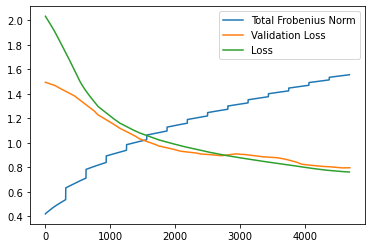

In [ ]:
## plot with smoothing (does not work for frobenius)

from matplotlib import pyplot as plt
%matplotlib inline
level = 1000

plt.plot(metrics["total_frobenius_norm"][0][0::5]/np.max(metrics["total_frobenius_norm"][0][0::5]) * np.max(metrics["loss"][1][0::5]))
plt.plot(smooth(metrics["loss"][1], level))
plt.plot(smooth(metrics["loss"][0][0::5], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

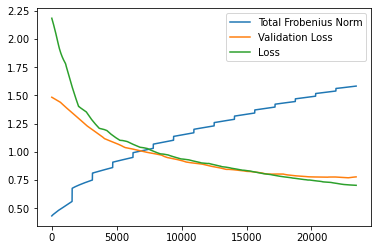

In [ ]:
## plot with smoothing (does not work for frobenius)

from matplotlib import pyplot as plt
%matplotlib inline
level = 1000

for name, (train_values, test_values) in metrics.items():
  train_values = len(train_values)
  test_values = len(test_values)


plt.plot(range(train_values), metrics["total_frobenius_norm"][0]/np.max(metrics["total_frobenius_norm"][0]) * np.max(metrics["loss"][1]))
plt.plot(np.arange(test_values)/test_values * train_values, smooth(metrics["loss"][1], level))
plt.plot(range(train_values), smooth(metrics["loss"][0], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

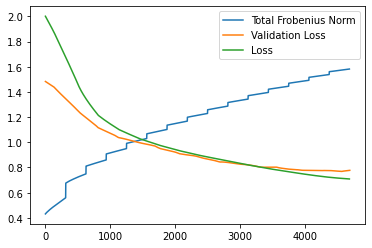

In [ ]:
## plot with smoothing (does not work for frobenius)

from matplotlib import pyplot as plt
%matplotlib inline
level = 1000

plt.plot(metrics["total_frobenius_norm"][0][0::5]/np.max(metrics["total_frobenius_norm"][0][0::5]) * np.max(metrics["loss"][1][0::5]))
plt.plot(smooth(metrics["loss"][1], level))
plt.plot(smooth(metrics["loss"][0][0::5], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

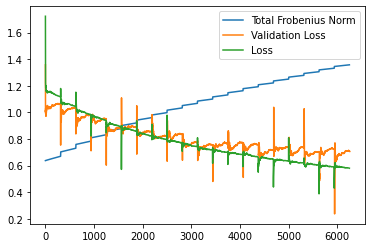

In [ ]:
## use shuffeled training data in each epoch + return to adam optimizer
## 20 epochs!

from matplotlib import pyplot as plt
%matplotlib inline

plt.plot(metrics["total_frobenius_norm"][0][0::5]/np.max(metrics["total_frobenius_norm"][0][0::5]) * np.max(metrics["loss"][1][0::5]))
plt.plot(metrics["loss"][1])
plt.plot(metrics["loss"][0][0::5])
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()
     

augmentation

In [ ]:
def get_cifar10(batch_size, augmentation=None):
    """
    Load and prepare CIFAR-10 as a tensorflow dataset.
    Returns a train and a validation dataset.
    Args:
    batch_size (int)
    """
    train_ds, val_ds = tfds.load('cifar10', split=['train', 'test'], shuffle_files=True)

    one_hot = lambda x: tf.one_hot(x, 10)

    map_func = lambda x,y: (tf.cast(x, dtype=tf.float32)/255.,
                            tf.cast(one_hot(y),tf.float32))

    map_func_2 = lambda x: (x["image"],x["label"])

    train_ds = train_ds.map(map_func_2).map(map_func).cache()
    val_ds   = val_ds.map(map_func_2).map(map_func).cache()
    
    train_ds = train_ds.shuffle(4096).batch(batch_size)
    val_ds   = val_ds.shuffle(4096).batch(batch_size)
    if augmentation:
        train_ds = train_ds.map(lambda x,y : (augmentation_model(x), y),num_parallel_calls=tf.data.AUTOTUNE)

    return (train_ds.prefetch(tf.data.AUTOTUNE), val_ds.prefetch(tf.data.AUTOTUNE))

In [ ]:
augmentation_model = tf.keras.Sequential([keras_cv.layers.RandAugment(value_range=[0,1],magnitude=0.1)])
train_augmented, val_augmented = get_cifar10(32, augmentation=augmentation_model)

In [ ]:
model = BasicConv()

metrics_augmented = training_loop(model, 15, 
          train_augmented, val_augmented, 
          train_summary_writer, val_summary_writer, 
          "regularized_model_label_smoothing")

Epoch 0:


100%|██████████| 1563/1563 [03:51<00:00,  6.74it/s]


['acc: 0.27250000834465027', 'top-3-acc: 0.5997400283813477', 'loss: 1.9382448196411133', 'total_frobenius_norm: 32.02973175048828']
['val_acc: 0.43630000948905945', 'val_top-3-acc: 0.7692999839782715', 'val_loss: 1.5754941701889038', 'val_total_frobenius_norm: 39.79322814941406']
Epoch 1:


100%|██████████| 1563/1563 [03:46<00:00,  6.91it/s]


['acc: 0.40988001227378845', 'top-3-acc: 0.748420000076294', 'loss: 1.615946650505066', 'total_frobenius_norm: 44.59905242919922']
['val_acc: 0.4884999990463257', 'val_top-3-acc: 0.8075000047683716', 'val_loss: 1.4093992710113525', 'val_total_frobenius_norm: 48.46001052856445']
Epoch 2:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.46955999732017517', 'top-3-acc: 0.7905799746513367', 'loss: 1.4746049642562866', 'total_frobenius_norm: 51.47820281982422']
['val_acc: 0.5504999756813049', 'val_top-3-acc: 0.8503000140190125', 'val_loss: 1.2594542503356934', 'val_total_frobenius_norm: 54.234195709228516']
Epoch 3:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.505840003490448', 'top-3-acc: 0.8163999915122986', 'loss: 1.3781858682632446', 'total_frobenius_norm: 56.65953063964844']
['val_acc: 0.5759999752044678', 'val_top-3-acc: 0.8669000267982483', 'val_loss: 1.1817876100540161', 'val_total_frobenius_norm: 58.95827865600586']
Epoch 4:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.5296599864959717', 'top-3-acc: 0.8313800096511841', 'loss: 1.3123958110809326', 'total_frobenius_norm: 60.891666412353516']
['val_acc: 0.5914000272750854', 'val_top-3-acc: 0.879800021648407', 'val_loss: 1.136146068572998', 'val_total_frobenius_norm: 62.80586624145508']
Epoch 5:


100%|██████████| 1563/1563 [03:49<00:00,  6.81it/s]


['acc: 0.5493800044059753', 'top-3-acc: 0.8425800204277039', 'loss: 1.267285704612732', 'total_frobenius_norm: 64.63426971435547']
['val_acc: 0.6216999888420105', 'val_top-3-acc: 0.8949999809265137', 'val_loss: 1.0582927465438843', 'val_total_frobenius_norm: 66.46479034423828']
Epoch 6:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.5689200162887573', 'top-3-acc: 0.8513200283050537', 'loss: 1.2214215993881226', 'total_frobenius_norm: 68.11347198486328']
['val_acc: 0.6310999989509583', 'val_top-3-acc: 0.8966000080108643', 'val_loss: 1.0301371812820435', 'val_total_frobenius_norm: 69.66596221923828']
Epoch 7:


100%|██████████| 1563/1563 [03:47<00:00,  6.86it/s]


['acc: 0.5778800249099731', 'top-3-acc: 0.8599399924278259', 'loss: 1.1872233152389526', 'total_frobenius_norm: 71.26640319824219']
['val_acc: 0.6238999962806702', 'val_top-3-acc: 0.8960000276565552', 'val_loss: 1.0472826957702637', 'val_total_frobenius_norm: 72.78654479980469']
Epoch 8:


100%|██████████| 1563/1563 [03:46<00:00,  6.89it/s]


['acc: 0.5889800190925598', 'top-3-acc: 0.8656600117683411', 'loss: 1.1551328897476196', 'total_frobenius_norm: 74.28234100341797']
['val_acc: 0.6462000012397766', 'val_top-3-acc: 0.8964999914169312', 'val_loss: 1.0074959993362427', 'val_total_frobenius_norm: 75.71746826171875']
Epoch 9:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.599839985370636', 'top-3-acc: 0.8720399737358093', 'loss: 1.1271820068359375', 'total_frobenius_norm: 77.07449340820312']
['val_acc: 0.6564000248908997', 'val_top-3-acc: 0.9068999886512756', 'val_loss: 0.9636437296867371', 'val_total_frobenius_norm: 78.39827728271484']
Epoch 10:


100%|██████████| 1563/1563 [03:41<00:00,  7.04it/s]


['acc: 0.6125400066375732', 'top-3-acc: 0.8769199848175049', 'loss: 1.103346347808838', 'total_frobenius_norm: 79.74635314941406']
['val_acc: 0.6696000099182129', 'val_top-3-acc: 0.9088000059127808', 'val_loss: 0.9334225654602051', 'val_total_frobenius_norm: 81.04496765136719']
Epoch 11:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.6185200214385986', 'top-3-acc: 0.8804799914360046', 'loss: 1.082809567451477', 'total_frobenius_norm: 82.27732849121094']
['val_acc: 0.6593999862670898', 'val_top-3-acc: 0.9060999751091003', 'val_loss: 0.9537097215652466', 'val_total_frobenius_norm: 83.51937866210938']
Epoch 12:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.6240000128746033', 'top-3-acc: 0.8832799792289734', 'loss: 1.062958836555481', 'total_frobenius_norm: 84.74090576171875']
['val_acc: 0.6800000071525574', 'val_top-3-acc: 0.9192000031471252', 'val_loss: 0.8963934779167175', 'val_total_frobenius_norm: 85.90444946289062']
Epoch 13:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.6323599815368652', 'top-3-acc: 0.8884199857711792', 'loss: 1.0399913787841797', 'total_frobenius_norm: 87.01256561279297']
['val_acc: 0.6930999755859375', 'val_top-3-acc: 0.9259999990463257', 'val_loss: 0.8629682660102844', 'val_total_frobenius_norm: 88.09769439697266']
Epoch 14:


100%|██████████| 1563/1563 [04:22<00:00,  5.96it/s]


['acc: 0.6380599737167358', 'top-3-acc: 0.8915200233459473', 'loss: 1.0236462354660034', 'total_frobenius_norm: 89.22499084472656']
['val_acc: 0.6916000247001648', 'val_top-3-acc: 0.9174000024795532', 'val_loss: 0.878311276435852', 'val_total_frobenius_norm: 90.35891723632812']


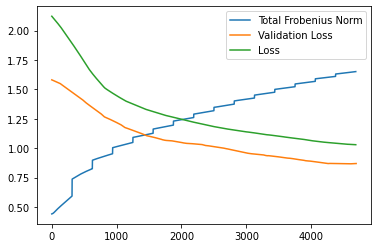

In [ ]:
## plot with smoothing (does not work for frobenius)

from matplotlib import pyplot as plt
%matplotlib inline
level = 1000

plt.plot(metrics_augmented["total_frobenius_norm"][0][0::5]/np.max(metrics_augmented["total_frobenius_norm"][0][0::5]) * np.max(metrics_augmented["loss"][1][0::5]))
plt.plot(smooth(metrics_augmented["loss"][1], level))
plt.plot(smooth(metrics_augmented["loss"][0][0::5], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

Dropout

In [ ]:
L2_reg=0
dropout_rate=0.5
batch_norm = False
label_smoothing=0

save_path = "regularized_model_label_smoothing"


model_dropout = BasicConv(L1_reg=0, L2_reg=L2_reg, dropout_rate=dropout_rate, batch_norm=batch_norm, label_smoothing=label_smoothing)

In [ ]:
metrics_dropout = training_loop(model_dropout, 15, 
          train, val, 
          train_summary_writer, val_summary_writer, 
          "regularized_model_label_smoothing")

Epoch 0:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10040000081062317', 'top-3-acc: 0.011640000157058239', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 1:


100%|██████████| 1563/1563 [03:49<00:00,  6.81it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 2:


100%|██████████| 1563/1563 [03:48<00:00,  6.83it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 3:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 4:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 5:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 6:


100%|██████████| 1563/1563 [03:52<00:00,  6.72it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 7:


100%|██████████| 1563/1563 [03:56<00:00,  6.61it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 8:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 9:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 10:


100%|██████████| 1563/1563 [03:52<00:00,  6.73it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 11:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 12:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 13:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']
Epoch 14:


100%|██████████| 1563/1563 [04:21<00:00,  5.97it/s]


['acc: 0.10000000149011612', 'top-3-acc: 0.0', 'loss: nan', 'total_frobenius_norm: nan']
['val_acc: 0.10000000149011612', 'val_top-3-acc: 0.0', 'val_loss: nan', 'val_total_frobenius_norm: nan']


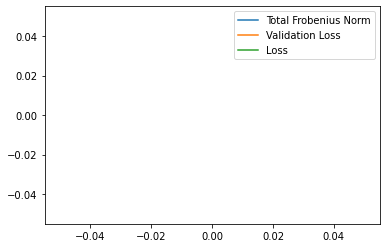

In [ ]:
plt.plot(metrics_dropout["total_frobenius_norm"][0][0::5]/np.max(metrics_dropout["total_frobenius_norm"][0][0::5]) * np.max(metrics_dropout["loss"][1][0::5]))
plt.plot(smooth(metrics_dropout["loss"][1], level))
plt.plot(smooth(metrics_dropout["loss"][0][0::5], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

L1

In [ ]:
L1_reg=0.001
dropout_rate=0
batch_norm = False
label_smoothing=0

model_L1 = BasicConv(L1_reg=L1_reg, L2_reg=0, dropout_rate=dropout_rate, batch_norm=batch_norm, label_smoothing=label_smoothing)

In [ ]:
metrics_L1 = training_loop(model_L1, 15, 
          train, val, 
          train_summary_writer, val_summary_writer, 
          "regularized_model_label_smoothing")

Epoch 0:


100%|██████████| 1563/1563 [03:09<00:00,  8.27it/s]


['acc: 0.37327998876571655', 'top-3-acc: 0.7192599773406982', 'loss: 1.6900676488876343', 'total_frobenius_norm: 31.034013748168945']
['val_acc: 0.483599990606308', 'val_top-3-acc: 0.8059999942779541', 'val_loss: 1.4465382099151611', 'val_total_frobenius_norm: 36.961936950683594']
Epoch 1:


100%|██████████| 1563/1563 [03:06<00:00,  8.39it/s]


['acc: 0.513759970664978', 'top-3-acc: 0.8271999955177307', 'loss: 1.363309621810913', 'total_frobenius_norm: 41.49675750732422']
['val_acc: 0.529699981212616', 'val_top-3-acc: 0.8425999879837036', 'val_loss: 1.281198263168335', 'val_total_frobenius_norm: 45.44728469848633']
Epoch 2:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.5780199766159058', 'top-3-acc: 0.8626599907875061', 'loss: 1.1988773345947266', 'total_frobenius_norm: 48.555030822753906']
['val_acc: 0.5685999989509583', 'val_top-3-acc: 0.8604999780654907', 'val_loss: 1.2282886505126953', 'val_total_frobenius_norm: 51.3723030090332']
Epoch 3:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6126000285148621', 'top-3-acc: 0.8798999786376953', 'loss: 1.0966308116912842', 'total_frobenius_norm: 53.78023910522461']
['val_acc: 0.5910999774932861', 'val_top-3-acc: 0.8751000165939331', 'val_loss: 1.1538883447647095', 'val_total_frobenius_norm: 56.1378173828125']
Epoch 4:


100%|██████████| 1563/1563 [03:06<00:00,  8.36it/s]


['acc: 0.6377000212669373', 'top-3-acc: 0.8936399817466736', 'loss: 1.0275532007217407', 'total_frobenius_norm: 58.255069732666016']
['val_acc: 0.6510000228881836', 'val_top-3-acc: 0.9027000069618225', 'val_loss: 0.9761709570884705', 'val_total_frobenius_norm: 60.33076477050781']
Epoch 5:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6573799848556519', 'top-3-acc: 0.9019799828529358', 'loss: 0.9774320721626282', 'total_frobenius_norm: 62.257503509521484']
['val_acc: 0.6601999998092651', 'val_top-3-acc: 0.9074000120162964', 'val_loss: 0.9538388252258301', 'val_total_frobenius_norm: 64.15624237060547']
Epoch 6:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6724600195884705', 'top-3-acc: 0.9099599719047546', 'loss: 0.933910608291626', 'total_frobenius_norm: 65.9142837524414']
['val_acc: 0.6723999977111816', 'val_top-3-acc: 0.9121999740600586', 'val_loss: 0.9193513989448547', 'val_total_frobenius_norm: 67.69339752197266']
Epoch 7:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6853600144386292', 'top-3-acc: 0.9162600040435791', 'loss: 0.897014856338501', 'total_frobenius_norm: 69.331298828125']
['val_acc: 0.6776999831199646', 'val_top-3-acc: 0.9156000018119812', 'val_loss: 0.914535403251648', 'val_total_frobenius_norm: 70.94854736328125']
Epoch 8:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.6962599754333496', 'top-3-acc: 0.9215199947357178', 'loss: 0.8670996427536011', 'total_frobenius_norm: 72.51956176757812']
['val_acc: 0.6901999711990356', 'val_top-3-acc: 0.9176999926567078', 'val_loss: 0.8892143368721008', 'val_total_frobenius_norm: 74.07242584228516']
Epoch 9:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.7056199908256531', 'top-3-acc: 0.9256799817085266', 'loss: 0.8403028249740601', 'total_frobenius_norm: 75.57176971435547']
['val_acc: 0.6872000098228455', 'val_top-3-acc: 0.9200000166893005', 'val_loss: 0.883988082408905', 'val_total_frobenius_norm: 77.07814025878906']
Epoch 10:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.7168999910354614', 'top-3-acc: 0.929419994354248', 'loss: 0.8088816404342651', 'total_frobenius_norm: 78.4808578491211']
['val_acc: 0.7006999850273132', 'val_top-3-acc: 0.9261999726295471', 'val_loss: 0.8433871269226074', 'val_total_frobenius_norm: 79.84909057617188']
Epoch 11:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.7248600125312805', 'top-3-acc: 0.9328799843788147', 'loss: 0.7856624126434326', 'total_frobenius_norm: 81.25501251220703']
['val_acc: 0.6930999755859375', 'val_top-3-acc: 0.9289000034332275', 'val_loss: 0.8651375770568848', 'val_total_frobenius_norm: 82.56057739257812']
Epoch 12:


100%|██████████| 1563/1563 [03:12<00:00,  8.11it/s]


['acc: 0.7358400225639343', 'top-3-acc: 0.9375', 'loss: 0.7594072818756104', 'total_frobenius_norm: 83.84892272949219']
['val_acc: 0.7175999879837036', 'val_top-3-acc: 0.9340000152587891', 'val_loss: 0.8136110901832581', 'val_total_frobenius_norm: 85.07437133789062']
Epoch 13:


100%|██████████| 1563/1563 [03:13<00:00,  8.07it/s]


['acc: 0.7430999875068665', 'top-3-acc: 0.9401400089263916', 'loss: 0.7373687028884888', 'total_frobenius_norm: 86.35367584228516']
['val_acc: 0.7121999859809875', 'val_top-3-acc: 0.9330000281333923', 'val_loss: 0.8082351088523865', 'val_total_frobenius_norm: 87.54434204101562']
Epoch 14:


100%|██████████| 1563/1563 [03:21<00:00,  7.74it/s]


['acc: 0.7501199841499329', 'top-3-acc: 0.9426599740982056', 'loss: 0.7180233597755432', 'total_frobenius_norm: 88.75773620605469']
['val_acc: 0.7265999913215637', 'val_top-3-acc: 0.9334999918937683', 'val_loss: 0.7932549715042114', 'val_total_frobenius_norm: 89.9197769165039']


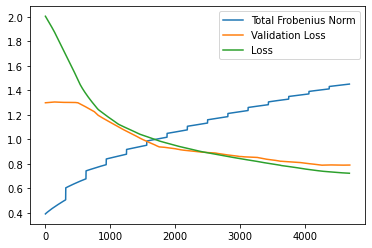

In [ ]:
plt.plot(metrics_L1["total_frobenius_norm"][0][0::5]/np.max(metrics_L1["total_frobenius_norm"][0][0::5]) * np.max(metrics_L1["loss"][1][0::5]))
plt.plot(smooth(metrics_L1["loss"][1], level))
plt.plot(smooth(metrics_L1["loss"][0][0::5], level))
plt.legend(labels=["Total Frobenius Norm", "Validation Loss", "Loss"])
# plt.savefig("convnet_no_reg.svg")
plt.show()

### Evaluation

The unoptimized model from last week slightly overfits  

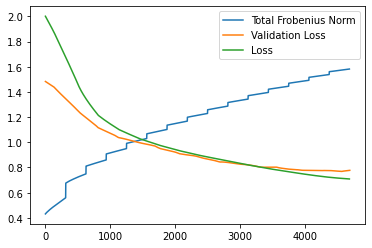

L2 regularisation - less overfitting

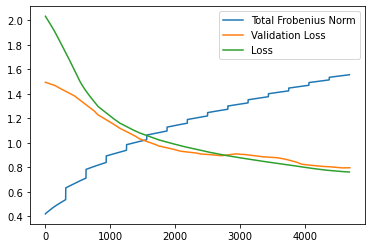

augmentation - no overfitting, validation loss is reasonably lower than trainings loss

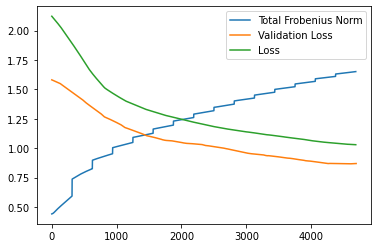

Dropout - didnt work -.-

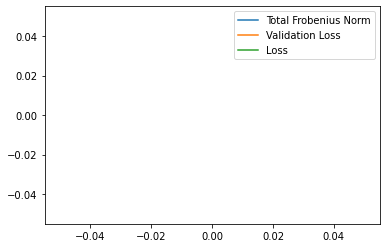

L1 - less overfitting, validation loss follows the training loss most accurately

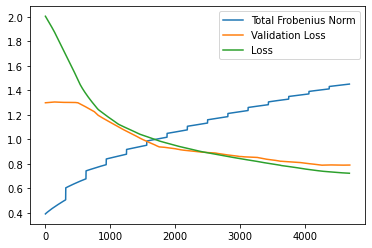